In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import torch
import numpy as np
import chnet.cahn_hill as ch
import matplotlib.pyplot as plt
from ipywidgets import interact
from toolz.curried import pipe, curry
from pymks.bases import LegendreBasis
from pymks import MKSLocalizationModel
warnings.filterwarnings('ignore')

In [3]:
@curry
def return_slice(x_data, cutoff):
    if cutoff is not None:
        return pipe(x_data,
                    lambda x_data: np.asarray(x_data.shape).astype(int) // 2,
                    lambda new_shape: [slice(new_shape[idim]-cutoff,
                                             new_shape[idim]+cutoff+1)
                                       for idim in range(x_data.ndim)],
                    lambda slices: x_data[slices])
    else:
        return x_data
    
cropper = return_slice(cutoff=7)

def draw_im(im, title=None):
    im = np.squeeze(im)
    plt.imshow(im)
    plt.colorbar()
    if title is not None:
        plt.title(title)
    plt.show()
    
def rmserror(x, y):
    return np.sqrt(np.mean((x - y)**2))

def init_unif(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    return np.random.uniform(-0.95, 0.95, size=(nsamples, dim_x, dim_y))


def init_norm(nsamples, dim_x, dim_y, seed=354875):
    np.random.seed(seed)
    means  = np.random.uniform(-0.1, 0.1, size=nsamples)
    scales  = np.random.uniform(0.1, 0.5, size=nsamples)
    
    x_data = [np.random.normal(loc=m, scale=s, size = (1, dim_x, dim_y)) for m,s in zip(means, scales)]
    x_data = np.concatenate(x_data, axis=0)
    
    np.clip(x_data, -0.95, 0.95, out=x_data)
    
    return x_data

## Generate Data

In [4]:
@curry
def data_generator(nsamples=128, 
                   dim_x=64, 
                   init_steps=100, 
                   delta_sim_steps = 500,
                   dx = 0.25, 
                   dt = 0.01,
                   gamma=1.0, 
                   seed = None,
                   device = torch.device("cuda:0")):
    
    init_data1 = init_unif(nsamples//2, dim_x, dim_x, seed=seed)
    init_data2 = init_norm(nsamples//2, dim_x, dim_x, seed=seed)
    init_data = np.concatenate([init_data1, init_data2], axis=0)
    
    x_data = ch.ch_run_torch(init_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps, device=device)
    y_data = ch.ch_run_torch(x_data, dt=dt, gamma=gamma, 
                             dx=dx, sim_step=init_steps+delta_sim_steps, device=device)
    return x_data, y_data

In [5]:
%%time
x_data, y_data = data_generator(nsamples=16, dim_x=64, 
                                init_steps=10, 
                                delta_sim_steps = 50,
                                dx = 0.25, 
                                dt = 0.01,
                                gamma=1.0, 
                                seed = None,
                                device = torch.device("cuda:0"))

CPU times: user 2.16 s, sys: 1.09 s, total: 3.25 s
Wall time: 6.94 s


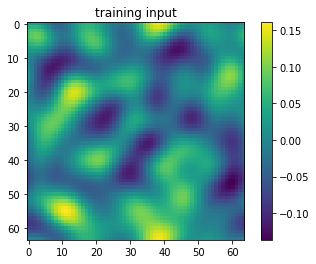

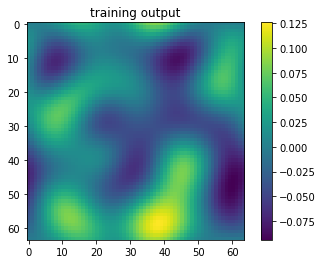

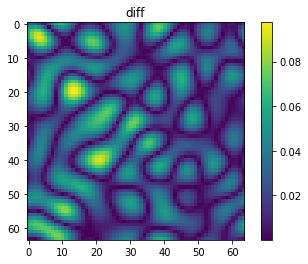

In [6]:
draw_im(x_data[0], "training input")
draw_im(y_data[0], "training output")

draw_im(np.fabs(x_data[0]-y_data[0]), "diff")

# or load saved microstructures from disk...

In [14]:
# nsamples = 1000
# x_data = np.load("data/unif/ch_5000_gamma_1000_dt_10_dx_250_101_unif.npy")[:nsamples]
# y_data = np.load("data/unif/ch_5100_gamma_1000_dt_10_dx_250_101_unif.npy")[:nsamples]

# x_val = np.load("data/unif/ch_5000_gamma_1000_dt_10_dx_250_101_unif.npy")[-nsamples:]
# y_val = np.load("data/unif/ch_5100_gamma_1000_dt_10_dx_250_101_unif.npy")[-nsamples:]

In [7]:
## Process Parameters
dim_x=64
init_steps=10
delta_sim_steps = 2000
dx = 0.25 
dt = 0.01
gamma=1.0

seed_trn = 110364
seed_val = 284296

n_samples_trn = 1024*10
n_samples_val = 128

init_features=32

In [8]:
%%time
x_trn, y_trn = data_generator(nsamples=n_samples_trn, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_trn,
                                device = torch.device("cuda:0"))

x_val, y_val = data_generator(nsamples=n_samples_val, 
                              dim_x=dim_x, 
                                init_steps=init_steps, 
                                delta_sim_steps = delta_sim_steps,
                                dx = dx, 
                                dt = dt,
                                gamma=gamma, 
                                seed =seed_val,
                                device = torch.device("cuda:0"))

CPU times: user 19.6 s, sys: 19.1 s, total: 38.7 s
Wall time: 37 s


In [9]:
n_states = 11
domain = (-1.1, 1.1)
basis = LegendreBasis(n_states, domain)
model = MKSLocalizationModel(basis)

In [10]:
%%time
model.fit(x_trn, y_trn)

CPU times: user 1min 23s, sys: 22.2 s, total: 1min 45s
Wall time: 31 s


In [11]:
%%time
y_mks = model.predict(x_val)

CPU times: user 1.58 s, sys: 265 ms, total: 1.84 s
Wall time: 370 ms


In [12]:
print(rmserror(y_mks, y_val))
print(rmserror(y_mks, x_val))

0.18258637587138782
0.41144252357068106


0.18258637587138782
0.41144252357068106


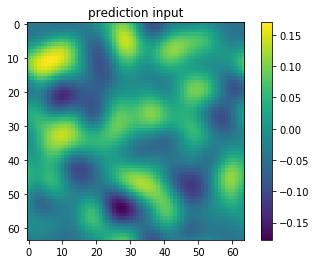

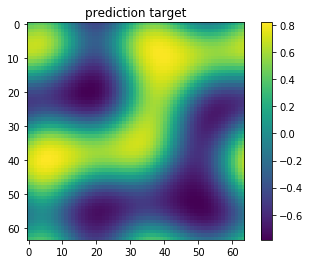

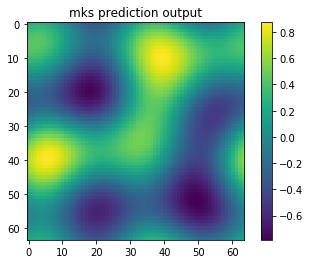

In [13]:
print(rmserror(y_mks, y_val))
print(rmserror(y_mks, x_val))

draw_im(x_val[0], "prediction input")
draw_im(y_val[0], "prediction target")
draw_im(y_mks[0], "mks prediction output")

# If we 

In [14]:
coeff = model.coef_
@interact
def draw(i = (0,n_states-1)):
#     plt.imshow(cropper(coeff[:,:,i]))
    plt.imshow(coeff[:,:,i])
    plt.colorbar()
    plt.show()

interactive(children=(IntSlider(value=5, description='i', max=10), Output()), _dom_classes=('widget-interact',…

## Predicting future timesteps using same kernels

In [15]:
%%time
steps = 10
y_pred = x_val.copy()
print(0, y_pred.shape, rmserror(y_pred, y_val))
for step in range(steps):
    try:
        y_pred = model.predict(y_pred)
        print(step+1, y_pred.shape, rmserror(y_pred, y_val))
    except Exception as err:
        print(step, err)
        break

0 (128, 64, 64) 0.4558503231405504
1 (128, 64, 64) 0.18258637587138782
1 X must be within the specified domain
CPU times: user 1.79 s, sys: 311 ms, total: 2.1 s
Wall time: 426 ms


# Comparision with unet-leg model

In [16]:
from torch.utils.data import Dataset, DataLoader
from chnet.ch_loader import CahnHillDataset

In [17]:
from chnet.unet import UNet
model = UNet(in_channels=7, 
             out_channels=1, 
             init_features=init_features).double().to(torch.device("cuda:0"))
model.load_state_dict(torch.load("out/unet/ch_unet_id_11-04-2020-12-27_run_legendre10/unet_epoch_98.pt"))

<All keys matched successfully>

In [18]:
n_states = 7
domain = (-1.01, 1.01)
basis = LegendreBasis(n_states, domain)
transformer_x = lambda x: np.moveaxis(basis.discretize(x), 3, 1)
x_cuda = torch.tensor(transformer_x(x_val)).double().cuda()


model.eval()
y_cnn = np.squeeze(model(x_cuda).detach().cpu().numpy())

0.03684620679909028
0.44035041363974053


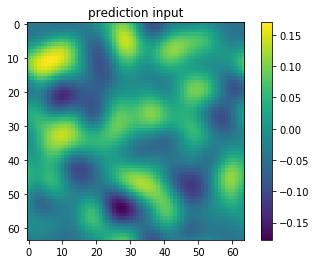

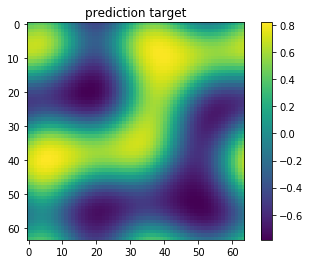

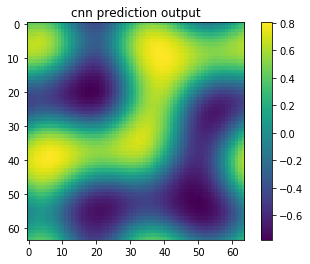

In [19]:
print(rmserror(y_cnn, y_val))
print(rmserror(y_cnn, x_val))

draw_im(x_val[0], "prediction input")
draw_im(y_val[0], "prediction target")
draw_im(y_cnn[0], "cnn prediction output")